# Modelo de Visão Computacional


## Introdução

A idéia geral do projeto para a Mottu era a de escanear o pátio com um robô que utilizasse IoT, para gerar uma espécie de planta baixa do pátio (pensando que cada pátio pode ter uma configuração espacial diferente). A partir dessa planta baixa o ADM da Mottu poderia delimitar zonas de depósito das motocicletas manualmente, que se comunicariam com o sistema via tags BLE (Bluetooth Low Energy) em cada uma das motos.

Ex de panta baixa que esperamos gerar: (as áreas em vermelho representam a delimitação de zonas)

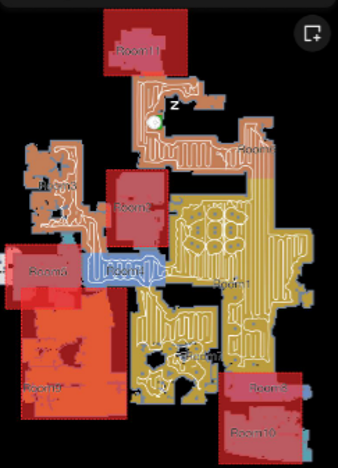


Inicialmente foi um pouco difícil pensar em aplicações para visão computacional nesse projeto que fizessem sentido com o nosso planejamento (além de uma pura análise de dados), mas depois de dar uma pensada eu cheguei na conclusão de que seria interessante utilizar a CV como um complemento que estivesse alinhado com o plano original.

Portanto, a ideia deste projeto é usar a Visão Computacional como uma ferramenta de análise prévia ou de suporte ao planejamento do pátio, ajudando o ADM a tomar decisões mais informadas antes de configurar as zonas no "Editor de Pátio" para posicionamento estratégico das zonas, basicamente um modelo que analisa o pátio e sugere áreas para o posicionamento das zonas.

Problema Real que o Protótipo CV Resolve (neste contexto auxiliar):
- Como um administrador pode ter uma visão inicial da densidade e distribuição típica de motos em um pátio antes de desenhar as zonas no sistema FLEET?
- Como identificar "gargalos" ou áreas de alta concentração que podem necessitar de atenção especial no layout das zonas?

Justificativa da Aplicação de CV:
- A CV pode processar imagens (estáticas ou de um vídeo curto) de um pátio para identificar automaticamente as motos e suas localizações relativas.
- Essa análise visual pode gerar insights (mapas de calor de densidade, sugestões de agrupamentos) que complementam o mapa de planta baixa do robô, oferecendo uma camada de "inteligência visual" para o planejamento.

## Preparação do Dataset

- Meta Inicial (para um primeiro ciclo de treino): 300 a 400 imagens diversas. O objetivo aqui é passar por todo o pipeline (coleta, anotação, treino, avaliação inicial) para identificar gargalos e ter um primeiro modelo funcional, mesmo que com limitações.

- Foco em Instâncias: Pelo menos algumas centenas de motos anotadas no total (500 imagens com uma média de 1-2 motos por imagem = 500-1000 instâncias).

- Estratégia de Coleta: Buscar variedade de ângulos, iluminação e cenários.

- Ferramenta de Anotação: https://www.makesense.ai/

- Processo de Anotação: Anotar as imagens desenhando bounding boxes ao redor de cada moto, e definir uma classe "MB" (MotorBike).

- Divisão do Dataset: dados de treino, validação e teste.

- Fontes:

 - http://velastin.dynu.com/videodatasets/UrbanMotorbike/mb10000.htm
 - https://www.kaggle.com/datasets/zwartfreak/bike-images
 - Imagens diversas da internet coletadas e anotadas manualmente

## Descrição do Dataset

- Número de Imagens: 852 imagens que através de augmentation (flips, rotação, brilho, exposição, blur e ruído) geraram "2 versões de cada", resultando em 1704 imagens no total, ajudando o modelo a generalizar melhor e a ser mais robusto a diferentes condições do mundo real, simulando uma variedade maior de dados a partir das imagens originais.

- Formato YOLO v5 PyTorch e arquivos .txt para as anotações.

- Divisão em pastas train (702 imagens), test (50 imagens, utilizadas APÓS o treinamento para uma avaliação final do modelo) e valid (100 imagens, utilizadas DURANTE o treinamento para verificação imparcial do modelo).

- Data.yml: aponta para os caminhos das pastas train, valid, e test, define o número de classes (nesse caso uma só, a classe MB) para associar as imagens e suas respectivas labels.

In [ ]:
# Ex. Data.yml:

train: train/images
val: valid/images
test: test/images

nc: 1
names: ['MB']

# Ex. label:
0 0.491796875 0.456640625 0.8265625 0.83828125

## Configuração inicial:

In [ ]:
!pip install ultralytics -q
!pip install opencv-python -q
!pip install scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00


Instalando a lib da Ultralytics para YOLOv8 (modelo pré-treinado de visão computacional).

Importante mencionar:
O dataset foi construido no formato "YOLO v5 Pytorch" por ser o mais compatível com o Makesense.ai, porém o modelo YOLO v8 foi escolhido por duas razões:

*   O formato do YOLO v5 é totalmente compatível com o YOLO v8, não apresentando impedimento para o treinamento sem necesscidade de conversão
*   Facilidade de uso, maior precisão e performance (necessário pelo uso limitado de GPU do plano free do collab)



In [ ]:
import torch
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import drive

drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [ ]:
# Confirmando que estamos usando a GPU:

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_info}")

Configuração das variáveis de ambiente:

In [ ]:
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab_Notebooks'
PROJECT_FOLDER_NAME = 'fleet_cv'
project_base_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, PROJECT_FOLDER_NAME)
dataset_yolo_path = os.path.join(project_base_path, 'datasets/yolo_motorcycle_detector/')
data_yaml_path = os.path.join(dataset_yolo_path, 'data.yaml')
trained_models_dir = os.path.join(project_base_path, 'trained_models/yolo_detector/')

Configuração do comando de treinamento do YOLO v8:

In [ ]:
MODEL_TO_TRAIN = 'yolov8n.pt' # nome do modelo (yolov8 nano, pra agilizar os testes nessa fase inicial)
NUM_EPOCHS = 30 # número de vezes que o modelo vai ver o dataset completo, a cada época o modelo pega métricas e reajusta os parametros internos para melhorar a acurácia
IMAGE_SIZE = 640 # tamanho para o qual as imagens são redimensionadas, no caso 640x640 pixels
BATCH_SIZE = 16 # número de imagens que o modelo processa de uma vez (ou seja se o conjunto de treino possui 702 imagens, ele vai precisar de 44 iterações para percorrer todo o set de treino), testei entre 8-16 para evitar problemas de memória com a GPU
EXPERIMENT_NAME = 'yolov8n_motorbike_detector_run1' # nome qualquer

In [ ]:
!yolo train model={MODEL_TO_TRAIN} data="{data_yaml_path}" epochs={NUM_EPOCHS} imgsz={IMAGE_SIZE} batch={BATCH_SIZE} project="{trained_models_dir}" name="{EXPERIMENT_NAME}"

100% 6.25M/6.25M [00:00<00:00, 388MB/s]
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_motorbike_detector_run1, nbs=64, nms=False

## Análise dos resultados iniciais

Interpretação do output:

In [ ]:
results_csv_path = '/content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/yolov8n_motorbike_detector_run1/results.csv'

In [ ]:
df_results = pd.read_csv(results_csv_path)
df_results.columns = df_results.columns.str.strip()

In [ ]:
print("Colunas:", df_results.columns.tolist())

Colunas: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Explicação das colunas relevantes para a análise:
- Epoch: O número da época atual
- train/box_loss: Perda da Caixa Delimitadora, ou seja, o quão erradas estão as coordenadas que o modelo previu COMPARADAS COM AS ANOTAÇÕES REAIS DOS DADOS TREINO, via-de-regra quanto menor o número melhor
- train/cls_loss: Perda da classificação, se o modelo classificou errado o conteúdo de uma caixa delimitadora como "MB" (motorbike), ou seja, o modelo analisa apenas o que está dentro da bounding box
- metrics/precision(B): Métrica de precisão calculada sobre o conjunto de validação após o treinamento daquela época (o B é um parametro interno do modelo que significa que é para a tarefa específica de detecção de bounding boxes)
- metrics/recall(B): Métrica de recall calculada sobre o conjunto de validação
- metrics/mAP50(B): Mean Average Precision, com um IoU (Intersection over Union) de 0.50, isso significa que uma detecção é contada como correta se a sobreposição entre a caixa prevista e a caixa real for de pelo menos 50% (e a classe for correta)
- metrics/mAP50-95(B): Basicamente o mesmo da coluna metrics/mAP50(B), porém com um IoU de 50 a 95%, o que exige que para um score alto nessa métrica, as bounding boxes que o modelo previu sejam muito mais precisas
- val/box_loss: similar à coluna train/box_loss, porém em comparação COM OS VALORES DO CONJUNTO DE VALIDAÇÃO
- val/cls_loss: similar à coluna train/cls_loss, porém em comparação COM OS VALORES DO CONJUNTO DE VALIDAÇÃO

In [ ]:
df_results

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,28.5675,1.36326,2.37549,1.74886,0.76335,0.10580,0.35325,0.16502,1.50407,3.23654,2.11413,0.000652,0.000652,0.000652
1,2,52.4712,1.44585,2.19587,1.83382,0.41952,0.43443,0.32399,0.13680,1.99793,3.33981,3.04545,0.001275,0.001275,0.001275
2,3,75.6425,1.54009,2.08045,1.86220,0.27021,0.25410,0.13740,0.04235,2.26649,3.00307,2.99847,0.001854,0.001854,0.001854
3,4,99.7984,1.53709,2.00175,1.85364,0.22871,0.22951,0.12301,0.03232,3.11791,3.99842,4.79531,0.001802,0.001802,0.001802
4,5,124.5950,1.56599,1.90451,1.89722,0.58882,0.36885,0.35361,0.15272,2.18718,2.14572,3.21726,0.001736,0.001736,0.001736
5,6,147.6430,1.50859,1.85535,1.84547,0.55488,0.43443,0.45059,0.18039,2.08926,1.83390,2.63129,0.001670,0.001670,0.001670
6,7,172.8750,1.49955,1.78490,1.83572,0.60409,0.45902,0.51074,0.22885,1.84318,1.72755,2.45906,0.001604,0.001604,0.001604
7,8,198.0870,1.43090,1.68166,1.78695,0.56981,0.48361,0.48935,0.19777,1.99175,1.86063,2.47884,0.001538,0.001538,0.001538
8,9,221.2700,1.42913,1.63305,1.77061,0.56699,0.48298,0.46791,0.20982,1.78161,2.17244,2.38272,0.001472,0.001472,0.001472
9,10,246.3020,1.42303,1.60662,1.75712,0.43880,0.34426,0.35632,0.15267,2.02946,2.26765,2.55794,0.001406,0.001406,0.001406


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
epochs = df_results['epoch']

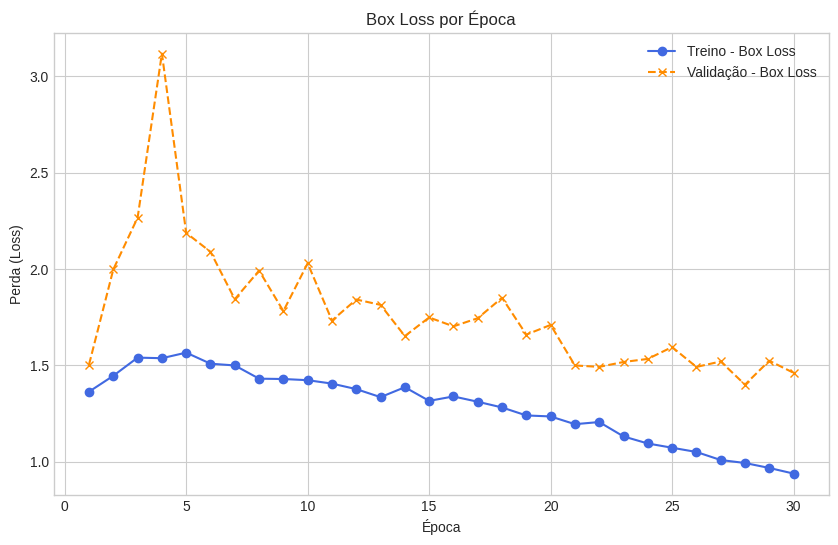

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['train/box_loss'], label='Treino - Box Loss', color='royalblue', marker='o', linestyle='-')
plt.plot(epochs, df_results['val/box_loss'], label='Validação - Box Loss', color='darkorange', marker='x', linestyle='--')
plt.title('Box Loss por Época')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

O gráfico de box loss basciamente mostra o seguinte:
- linha azul: o quão bem o modelo está acertando a posição e o tamanho das boxes nas imagens que ele está usando pra treinar (lembrando que quanto menor o valor, menor a taxa de erro, ou seja, o modelo acertou mais)

- linha laranja: o quão bem o modelo consegue generaliza essa habilidade tentando acertar a posição e o tamanho das boxes em imagens que ele nunca viu antes, no caso nosso conjunto de validação


Comportamento da loss:
- nas épocas 1-5 durante o treino e a validação o modelo teve uma taxa maior de erros, com um pico acentuado durante a validação da época 4, pelos padrões de outros modelos que eu vi, eu imagino que isso não seja incomum já que no começo do processo o modelo faz grandes ajustes nos pesos para "explorar as possiblidades" enquanto ele não generaliza bem

- nas épocas 6-25 o comportamento das duas linhas padroniza, levando a uma melhora gradual e menos loss (apesar de ainda terem variações mais acentuadas na etapa de validação, o fato da linha não tem uma subida constante, o que é um bom sinal)

- nas épocas 26-30 apesar da instabilidade inicial e das flutuações ambas linhas apresentam um padrão descendente constante e gradual o que indica que o modelo está aprendendo a reconheçer os padrões

IMPORTANTE: um bom sinal também é que o fato das duas linhas apresentarem um padrão parecido indica que o modelo não está com overfitting, se fosse esse o caso a tendencia era a linha de teste permanecer num padrão descendente enquanto a linha da validação estaria ascendendo constantemente (a val/box_loss parece ter estabilizado um pouco mais ali perto do final, mas não parece ser uma subida muito preocupante)



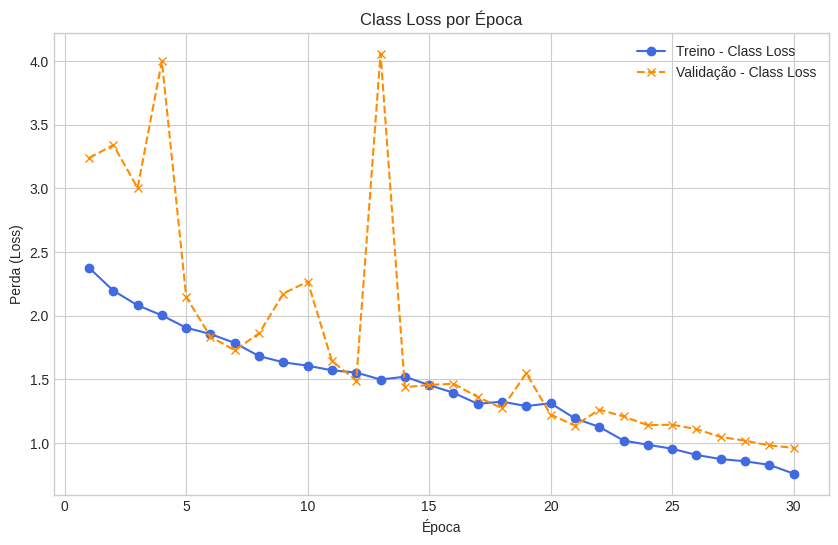

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['train/cls_loss'], label='Treino - Class Loss', color='royalblue', marker='o', linestyle='-')
plt.plot(epochs, df_results['val/cls_loss'], label='Validação - Class Loss', color='darkorange', marker='x', linestyle='--')
plt.title('Class Loss por Época')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

O gráfico de class loss vai indicar o quão bem o modelo, depois de delimitar a bounding box, consegue identificar o que está dentro dela como sendo uma moto (MB) ou não. (valor menor = melhor)

Treino:
- as épocas 1-7 indiciam uma queda rápida no valor da loss o que indica que o modelo aprendeu relativamente rápido as caracteristicas mais óbvias para conseguir identificar uma moto

- épocas 8-30 continuam com o padrão de diminuição gradual, o que significa que o modelo está ficando cada vez melhor em classificar corretamente as motos no conjunto de dados que ele está usando para aprender

Validação:
- épocas 1-15 mostram picos de instabilidade consideráveis no inicio, com um pico enorme entre as épocas 4 e 5, ultrapassando 4.0 e um segundo entre as épocas 13-14, também acima de 4.0. Isso pode ser por causa de ajustes nos pesos que acabam não generalizando bem para imagens nunca vistas antes em um modelo que ainda está imaturo

- já as épocas 16-30 mostram uma boa recuperação e a convergência com a linha de treino (muito positivo), em alguns momentos apresentando até uma taxa de loss menor do que a de treino, ou seja, o modelo conseguiu se recuperar e aprender a generalizar sua capacidade de classificação para o conjunto de validação

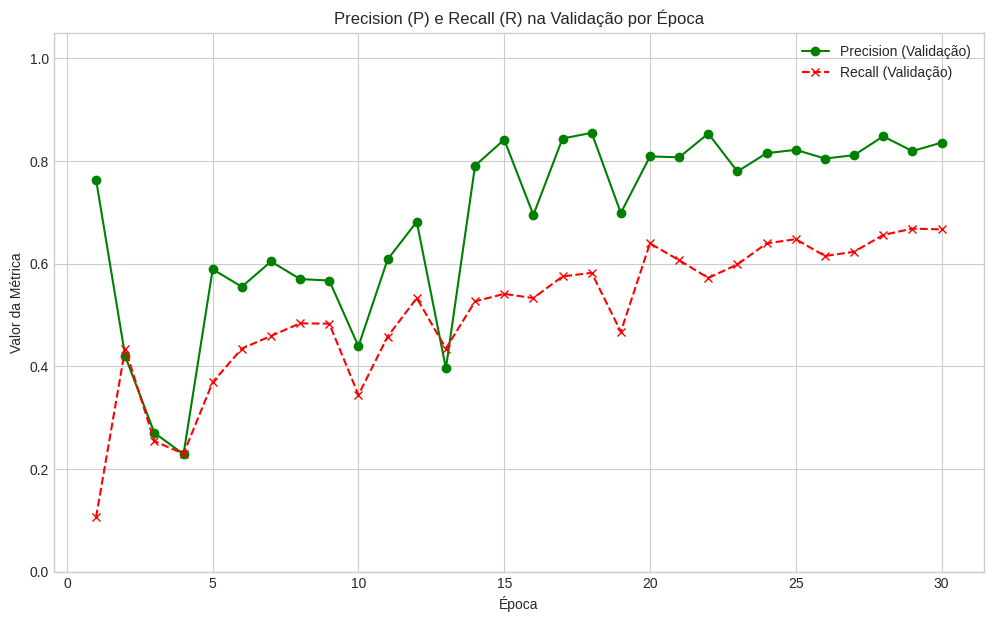

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(epochs, df_results['metrics/precision(B)'], label='Precision (Validação)', color='green', marker='o', linestyle='-')
plt.plot(epochs, df_results['metrics/recall(B)'], label='Recall (Validação)', color='red', marker='x', linestyle='--')
plt.title('Precision (P) e Recall (R) na Validação por Época')
plt.xlabel('Época')
plt.ylabel('Valor da Métrica')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

Inicialmente tinha feito dois gráficos separados para analisar precisão e recall mas eu percebi que o recall dava uns insights importantes sobre a precisão então optei por juntar os dois. A linha de precisão (verde) basicamente indica quantas vezes por época o modelo disse "isso é uma moto" e estava certo, quanto maior o valor de precisão, mais vezes o modelo estava correto. Já a linha de recall (vermelha), indica quantas motos o modelo conseguiu encontrar de todas que existiam na imagem.

-época 1 começa com uma precisão supreendetemente alta em torno de 76%, mas um recall baixíssimo com cerca de 10%, ou seja o modelo encontrou só 10% das motos das imagens, mas as que ele "se arriscou" a dizer que eram de fato uma moto estavam corretas 76% das vezes. Nesse estágio inicial o modelo parece estar operando de uma maneira bem conservadora, já que ele ainda não aprendeu bem as caracteristicas que definem uma moto, e só faz uma detecção quando tem um grau de confiança muito alto.

- épocas 2-4 a precisão despenca atingindo o ponto mais baixo de cerca de 23% na época 4, enquanto o recall começa a aumentar um pouco, isso coincide com a fase de ajustes dos pesos dos gráficos anteriores e mostra uma consistencia nesse sentido de uma fase de adaptação durante a validação nesse período. O modelo ainda está meio "perdido" tentando aprender

- nas épocas 5-13 as métricas vão se recuperando um pouco mais ainda continuam muito voláteis e com níveis medianos baixos, e fica oscilando, quando um sobre o outro pode não acompanhar ou ter uma queda. O modelo aidna está numa fase de exploração e ajustes, essa oscilação pode ser explicada pelo modelo tentando ser mais "corajoso" pra tentar achar mais motos, mas com o custo de errar mais

- na época 14 parece que temos um ponto de virada, a precisão da um salto enorme, pra cerca de 80% e o recall pra mais de 50%, modelo parece ter encontrado um caminho de aprendizado mais eficaz

- e finalmente, nas épocas 15-30 as curvas vão aumentando gradualmente até chegar no seu nível mais alto e estável, o modelo parece estar mais preciso, mas ainda tem o recall como sendo a parte mais dificil para ele

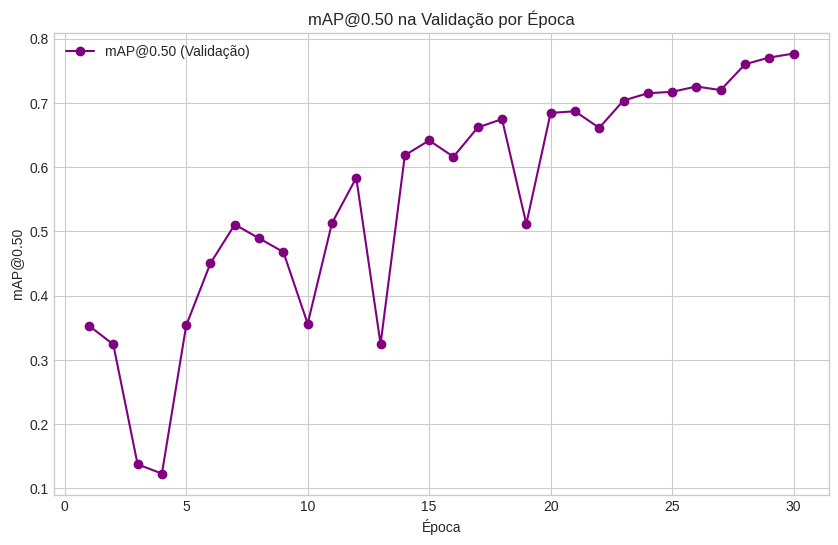

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['metrics/mAP50(B)'], label='mAP@0.50 (Validação)', color='purple', marker='o')
plt.title('mAP@0.50 na Validação por Época')
plt.xlabel('Época')
plt.ylabel('mAP@0.50')
plt.legend()
plt.grid(True)
plt.show()

Esse é um dos gráficos mais importantes já que o mean average precision (mAP) é uma métrica chave que resume a performance geral do detector. Lembrando que para um resultado positivo dessa métrica o modelo precisa ter uma precisão de pelo menos 50% entre a box prevista e a box que foi anotada manualmente, além de ter classificado o objeto dentro da box corretamente

- nas épocas 1-4, novamente fase de ajustes de pesos, não vou me alongar muito

- nas épocas 5-7 temos uma subida que indicia que o modelo começou a aprender bem, já que um mAP@0.50 acima de 0.5 significa que, em média, o modelo esta acertando mais da metade das detecções com uma sobreposição entre caixa prevista/real aceitável, isso acontece provavelmente pq a precisão e o recall começaram a melhorar também

- nas épocas 8-20 temos uma melhora gradual, mesmo que com alguns picos de volatilidade, o pico na época 12 coincide com a fase em que o recall e a precisão tiveram valores bons simultaneamente, impulsionando o modelo para cima

- nas épocas 21-30 temos uma subida mais consistente, e bem mais gradual, que indica  uma fase final de otimização. interessante que o fato da reta continuar subindo até o final sugere que talvez ainda houvesse um espaço pra melhora com mais algumas épocas, mas pra essa primeira fase um mAP@0.50 de aproximadamente 77% ta bem sólido

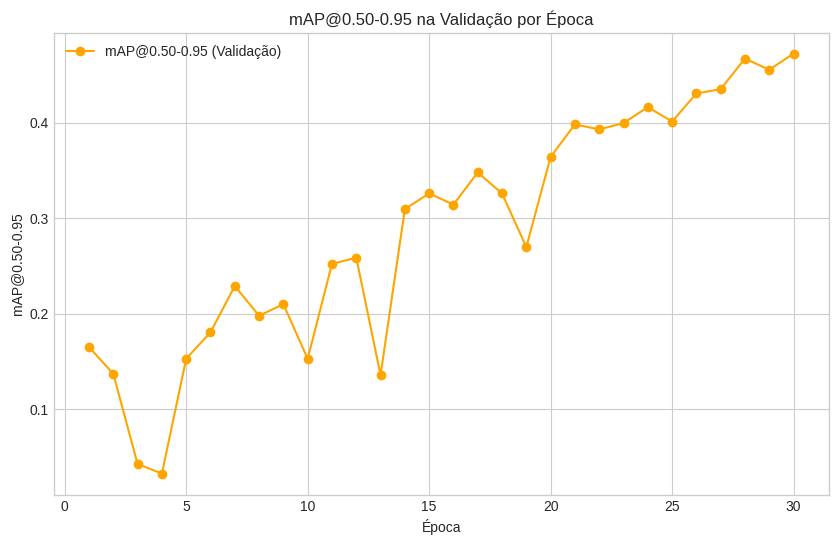

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['metrics/mAP50-95(B)'], label='mAP@0.50-0.95 (Validação)', color='orange', marker='o')
plt.title('mAP@0.50-0.95 na Validação por Época')
plt.xlabel('Época')
plt.ylabel('mAP@0.50-0.95')
plt.legend()
plt.grid(True)
plt.show()

Gráfico de mAP@0.50-0.95, ou seja, já exige uma precisão muito maior na localização, já que calcula a média do mAP para um IoU de 50 até 95% o score depende das caixas estarem quase perfeitamente alinhadas com os objetos. Se parece muito com o gráfico anterior já que ambas as métricas (mAP@0.50 e mAP@0.50-0.95) medem a performance geral da detecção, se o modelo estiver aprendendo como deveria, o comportamento esperado é que ambas as métricas sigam uma tendência similar de subida ao longo das épocas, porém com uma diferenã fundamental, os valores absolutos (eixo y) do mAP@0.50-0.95 são significativamente mais baixos que os do mAP@0.50.

- as épocas 1-20 seguem basicamente o mesmo padrão de comportamento analisado anteriormente porém entre valores de 10/40%, nenhuma observação adicional é necessária

- ja as ultimas 9 épocas (21-30) é a fase onde o modelo realmente refina a precisão das suas caixas delimitadoras. Atingir um mAP@0.50-0.95 de cerca de 47% com um modelo nano em 30 épocas está dentro do padrão esperado para uma primeira entrega, mas tem espaço para melhora significativa.

## Conclusão da primeira etapa

In [ ]:
# Determinando a época com os melhores scores overall

# Melhor mAP50-95
best_map50_95_epoch = df_results['metrics/mAP50-95(B)'].idxmax()
best_map50_95_value = df_results['metrics/mAP50-95(B)'].max()
actual_epoch_map50_95 = df_results.loc[best_map50_95_epoch, 'epoch']

print(f"\nMelhor metrics/mAP50-95: {best_map50_95_value:.4f} na Época DataFrame (índice {best_map50_95_epoch}), Época Real ~{int(actual_epoch_map50_95)}")
print(f"Valores nessa época: \n{df_results.iloc[best_map50_95_epoch]}")

# Melhor mAP50
best_map50_epoch = df_results['metrics/mAP50(B)'].idxmax()
best_map50_value = df_results['metrics/mAP50(B)'].max()
actual_epoch_map50 = df_results.loc[best_map50_epoch, 'epoch']

print(f"\nMelhor metrics/mAP50(B): {best_map50_value:.4f} na Época DataFrame (índice {best_map50_epoch}), Época Real ~{int(actual_epoch_map50)}")
print(f"Valores nessa época: \n{df_results.iloc[best_map50_epoch]}")

# Melhor Precision
best_precision_epoch = df_results['metrics/precision(B)'].idxmax()
best_precision_value = df_results['metrics/precision(B)'].max()
actual_epoch_precision = df_results.loc[best_precision_epoch, 'epoch']

print(f"\nMelhor metrics/precision(B): {best_precision_value:.4f} na Época DataFrame (índice {best_precision_epoch}), Época Real ~{int(actual_epoch_precision)}")
print(f"Valores nessa época: \n{df_results.iloc[best_precision_epoch]}")

# Melhor Recall
best_recall_epoch = df_results['metrics/recall(B)'].idxmax()
best_recall_value = df_results['metrics/recall(B)'].max()
actual_epoch_recall = df_results.loc[best_recall_epoch, 'epoch']

print(f"\nMelhor metrics/recall(B): {best_recall_value:.4f} na Época DataFrame (índice {best_recall_epoch}), Época Real ~{int(actual_epoch_recall)}")
print(f"Valores nessa época: \n{df_results.iloc[best_recall_epoch]}")


Melhor metrics/mAP50-95: 0.4725 na Época DataFrame (índice 29), Época Real ~30
Valores nessa época: 
epoch                    30.000000
time                    730.673000
train/box_loss            0.938350
train/cls_loss            0.759330
train/dfl_loss            1.465540
metrics/precision(B)      0.835610
metrics/recall(B)         0.666650
metrics/mAP50(B)          0.776890
metrics/mAP50-95(B)       0.472480
val/box_loss              1.461290
val/cls_loss              0.961340
val/dfl_loss              1.908280
lr/pg0                    0.000086
lr/pg1                    0.000086
lr/pg2                    0.000086
Name: 29, dtype: float64

Melhor metrics/mAP50(B): 0.7769 na Época DataFrame (índice 29), Época Real ~30
Valores nessa época: 
epoch                    30.000000
time                    730.673000
train/box_loss            0.938350
train/cls_loss            0.759330
train/dfl_loss            1.465540
metrics/precision(B)      0.835610
metrics/recall(B)         0.666650
m

De maneira geral, analisando as métricas, a melhor época para prosseguir com o fine tuning do modelo é a época 30, pois:

- metrics/mAP50-95(B): A métrica mais importante para determinar o "melhor" modelo, pois é a mais rigorosa, exigindo boa classificação e localização precisa em vários níveis de sobreposição

- metrics/mAP50(B): Indica um bom desempenho geral com uma exigência de sobreposição mais relaxada (ambas mAP atingiram o pico na mesma época)

- O pico de Precisão (0.8547) ocorreu na Época 18. No entanto, nessa mesma Época 18:
 - O Recall era 0.5820 (significativamente menor que o pico de Recall)
 - mAP50(0.6749) e metrics/mAP50-95(0.3259), bem menores que o pico

- O melhor recall aconteceu na época 29, que também tinha bons valores de precisão, mPA0.50 e mPA0.50-0.95, mas no geral a época 30 se mostrou ligeiramente superior, mesmo sacrificando um pouco da precissão em nome de uma taxa de recall maior.

Carregando a melhor época escolhida pelo YOLO:

Por mais que o YOLO analise as métricas por si só e escolha o melhor modelo, eu achei interessante fazer essa análise cruzada pra tentar entender como o YOLO determinava isso, o que estava acontecendo no geral e comparar se o melhor modelo escolhido pelo YOLO (época 30) coincidiria com a minha interpretação das métricas

In [ ]:
path_to_best_pt = os.path.join(trained_models_dir, EXPERIMENT_NAME, 'weights/best.pt')

In [ ]:
model = YOLO(path_to_best_pt)
metrics = model.val(data=data_yaml_path, split='val', imgsz=640, save_json=False, save_hybrid=False)

# mAP50-95
map50_95 = metrics.box.map
print(f"mAP@0.50-0.95 (mAP geral): {map50_95:.4f}")

# mAP50
map50 = metrics.box.map50
print(f"mAP@0.50: {map50:.4f}")

# mAP75 (mAP com IoU de 0.75)
map75 = metrics.box.map75
print(f"mAP@0.75: {map75:.4f}")


print(metrics.results_dict.keys())

if 'metrics/precision(B)' in metrics.results_dict and 'metrics/recall(B)' in metrics.results_dict:
  precision_b = metrics.results_dict['metrics/precision(B)']
  recall_b = metrics.results_dict['metrics/recall(B)']
  print(f"Precision(B) do results_dict: {precision_b:.4f}")
  print(f"Recall(B) do results_dict: {recall_b:.4f}")

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 5.8±11.4 ms, read: 40.9±22.3 MB/s, size: 215.1 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/valid/labels.cache... 100 images, 22 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.46s/it]


                   all        100        122      0.836      0.667      0.776      0.471
Speed: 6.6ms preprocess, 274.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val3
mAP@0.50-0.95 (mAP geral): 0.4709
mAP@0.50: 0.7763
mAP@0.75: 0.4729
dict_keys(['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'fitness'])
Precision(B) do results_dict: 0.8356
Recall(B) do results_dict: 0.6667


## Analisando o melhor modelo

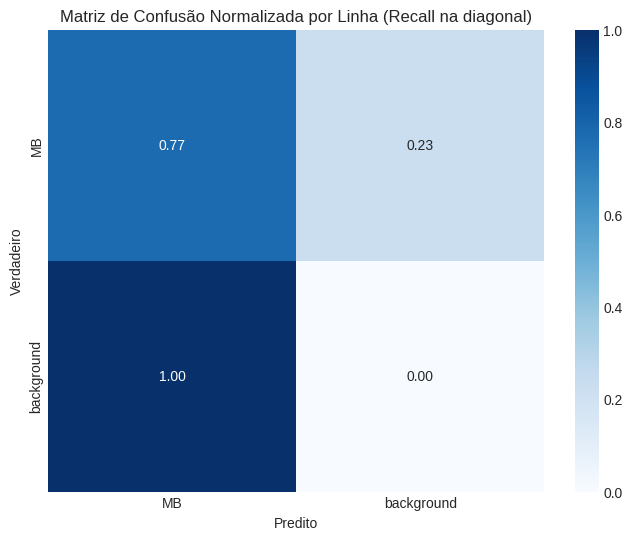

In [ ]:
conf_matrix_raw = metrics.confusion_matrix.matrix
class_plot_names = ['MB', 'background']

row_sums = conf_matrix_raw.sum(axis=1)
conf_matrix_normalized_row = conf_matrix_raw.astype('float') / (row_sums[:, np.newaxis] + 1e-6)
conf_matrix_normalized_row = np.nan_to_num(conf_matrix_normalized_row)

df_cm_normalized_row = pd.DataFrame(conf_matrix_normalized_row, index=class_plot_names, columns=class_plot_names)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm_normalized_row, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title('Matriz de Confusão Normalizada por Linha (Recall na diagonal)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

- O modelo demonstrou um Recall de 77% para a classe 'MB', ou seja, os 23% restantes das motos verdadeiras foram perdidas pelo detector ou classificadas incorretamente como background (falsos negativos)

- Já na linha do true background, a normalização mostra que 100% das instâncias contabilizadas nessa linha específica como true background e que o modelo previu como 'MB' são falsos positivos (modelo detectou uma moto onde não deveria)

In [ ]:
metrics_test = model.val(
  data=data_yaml_path,
  split='test',
  imgsz=640,
  batch=16,
  project=os.path.join(project_base_path, 'trained_models/yolo_detector/'),
  name='best_pt_FINAL_EVAL_on_test_set',
  save_json=True,
  save_hybrid=False
)

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 79.2±23.7 MB/s, size: 273.9 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/test/labels... 50 images, 11 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 93.46it/s]

val: New cache created: /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.12s/it]


                   all         50         69       0.89      0.812      0.879      0.539
Speed: 8.1ms preprocess, 281.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Saving /content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/best_pt_FINAL_EVAL_on_test_set3/predictions.json...
Results saved to /content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/best_pt_FINAL_EVAL_on_test_set3


In [ ]:
if hasattr(metrics_test, 'box') and metrics_test.box is not None:
  print(f"mAP@0.50-0.95 (Teste): {metrics_test.box.map:.4f}")
  print(f"mAP@0.50 (Teste): {metrics_test.box.map50:.4f}")

  precision_test = metrics_test.results_dict['metrics/precision(B)']
  recall_test = metrics_test.results_dict['metrics/recall(B)']
  print(f"Precision(B) (Teste): {precision_test:.4f}")
  print(f"Recall(B) (Teste): {recall_test:.4f}")

mAP@0.50-0.95 (Teste): 0.5388
mAP@0.50 (Teste): 0.8789
Precision(B) (Teste): 0.8904
Recall(B) (Teste): 0.8116


Comparando com os resultados no conjunto de validação do best.pt:

mAP@0.50-0.95 (Val): 0.473

mAP@0.50 (Val): 0.777

Precision(B) (Val): 0.836

Recall(B) (Val): 0.667
<br>
<br>

- Surpreendentemente o modelo performou melhor no conjunto de teste do que no de validação em mAP@0.50-0.95, um aumento de mais de 6%

- mAP@0.50: Novamente, um resultado superior no conjunto de teste, com um aumento de mais de 10%

- A precisão também foi maior, quando o modelo detectou uma moto no conjunto de teste, ele acertou 89% das vezes (menos falsos positivos)

- Agora o ganho mais impressionante, o recall no conjunto de teste é muito superior ao da validação (quase 15%)

O fato do modelo ter performado melhor no conjunto de teste do que no conjunto de validação é muito bom, mas também inesperado (esperava uma performance parecida ou um pouco inferior)

Agora testando o modelo de verdade

In [ ]:
from PIL import Image
import cv2

In [ ]:
test_media_images_path = os.path.join(project_base_path, 'test_media/images/')
example_image_name = [f for f in os.listdir(test_media_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))][0]
image_files_to_process = [f for f in os.listdir(test_media_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

In [ ]:
for image_name in image_files_to_process:
  image_to_test_path = os.path.join(test_media_images_path, image_name)
  try:
    # limiar de confiança de 25% no mínimo
    results = model.predict(source=image_to_test_path, save=False, conf=0.25)

    # O results é uma lista com um elemento para uma única imagem
    for r in results:
      # O método `r.plot()` desenha as caixas delimitadoras e rótulos na imagem e retorna um array NumPy da imagem no formato BGR
      img_with_detections_bgr = r.plot()
      img_with_detections_rgb = cv2.cvtColor(img_with_detections_bgr, cv2.COLOR_BGR2RGB)

      print("-------------------------------------------------------------------------------------------------------------------------------------")
      # mostrar com matplotlib
      plt.figure(figsize=(5, 5))
      plt.imshow(img_with_detections_rgb)
      plt.title(f"Detecções em: {image_name}")
      plt.axis('off')
      plt.show()

      print(f"\n--- Detalhes das Detecções para {image_name} ---")
      boxes = r.boxes
      if len(boxes.cls) > 0:
        for i in range(len(boxes.cls)):
          classe = model.names[int(boxes.cls[i])]
          confianca = boxes.conf[i]
          coordenadas_xyxy = boxes.xyxy[i]

          print(f"Objeto {i+1}: Classe={classe}, Confiança={confianca:.2f}, Coordenadas={coordenadas_xyxy.numpy().astype(int).tolist()}")
      else:
        print("Nenhum objeto detectado nesta imagem com o limiar de confiança especificado.")
        print("------------------------------------------------------------------------")

  except Exception as e:
        print(f"Ocorreu um erro ao processar a imagem {image_name}: {e}")
        print("------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

Dificuldades do teste inicial:

- Motos Pequenas e Motos Vistas de Cima

- Motos em Grandes Aglomerações (muita oclusão)

Obs:

O Non-Maximum Suppression (NMS) do YOLO é uma etapa que remove caixas delimitadoras redundantes e muito sobrepostas. Se as motos estão muito juntas, o NMS pode suprimir detecções individuais se as caixas delas se sobrepuserem demais, interpretando como detecções múltiplas do mesmo objeto, o que não é um problema por si só, já que a ideia inicial é apenas identificar onde há uma concentração de motos para um planejamento de zonas, o comportamento atual (detectar a aglomeração como um todo) já da uma informação útil.

Porém para uma etapa posterior de fine tuning do modelo pra um planejamento de zonas mais refinado (definir capacidade exata da zona, otimizar o layout interno da zona), apenas saber que é uma aglomeração sem saber quantas motos existem de fato é menos útil.

## Lógica de Clustering

Seguindo a lógica da solução inicial de propor um sistema de identificação e sugestão de áreas de zoneamento, nessa etapa a ideia é usar o modelo mesmo em fase inicial de treinamento para propor uma POC (Proof-of-Concept) da viabilidade da aplicação da solução em um cenário real (futuramente após fine tuning a proposta do modelo é funcionar também com vídeos curtos ou imagens de cameras de segurança).

In [ ]:
from sklearn.cluster import KMeans

Para isso iremos utilizar clusterização com K-Means

In [ ]:
IMAGE_TO_ANALYZE = '14.jpg'
NUM_CLUSTERS = 3 # O número de max clusters corresponderá no futuro ao número de zonas que a Mottu trabalha em seus pátios

In [ ]:
image_path = os.path.join(test_media_images_path, IMAGE_TO_ANALYZE)
results = model.predict(source=image_path, conf=0.15, save=False)
result = results[0]
image_with_yolo_detections_bgr = result.plot()
boxes_xyxy = result.boxes.xyxy.cpu().numpy()

detected_centers = []
for box in boxes_xyxy:
  x_min, y_min, x_max, y_max = box
  center_x = (x_min + x_max) / 2
  center_y = (y_min + y_max) / 2
  detected_centers.append([center_x, center_y])

detected_centers_np = np.array(detected_centers)

print(f"Número de motos detectadas: {len(detected_centers_np)}")
print("Centros das motos detectadas (X, Y):\n", detected_centers_np)


image 1/1 /content/drive/MyDrive/Colab_Notebooks/fleet_cv/test_media/images/14.jpg: 416x640 12 MBs, 130.7ms
Speed: 4.6ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
Número de motos detectadas: 12
Centros das motos detectadas (X, Y):
 [[     139.43      479.45]
 [     456.85      426.96]
 [     931.14      429.34]
 [     907.36      473.77]
 [     485.74      423.41]
 [     172.81      467.07]
 [     445.84      416.26]
 [     652.87      387.52]
 [     191.06      457.32]
 [     462.76      429.13]
 [     183.54      472.61]
 [     498.75       419.2]]


Tratamos a imagem como uma matriz onde cada pixel corresponde a uma coordenada em um plano bidimensional, assim como as boxes geradas no modelo tem suas coordenadas fixas nos eixos X/Y, possibilitando a plotagem das motos individualmente com um scatter plot

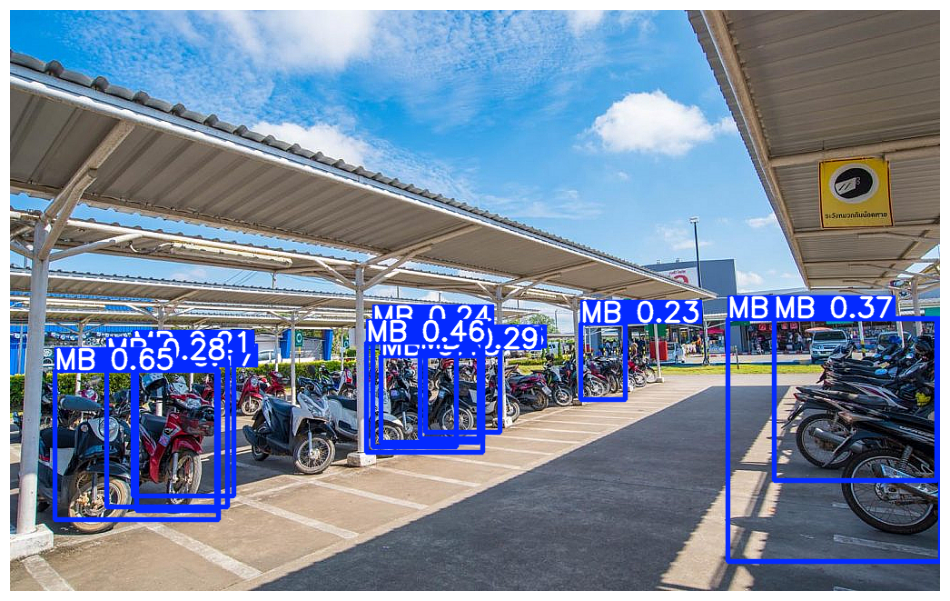

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
image_rgb_yolo_plot = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_yolo_plot)
plt.axis('off')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(detected_centers_np)
cluster_centers = kmeans.cluster_centers_

print(f"\n--- Resultados da Clusterização para {NUM_CLUSTERS} Clusters ---")
for i in range(NUM_CLUSTERS):
    print(f"Zona Sugerida {i+1} (Centroide): X={cluster_centers[i,0]:.0f}, Y={cluster_centers[i,1]:.0f}")
print("Labels dos clusters para cada moto:\n", cluster_labels)


--- Resultados da Clusterização para 3 Clusters ---
Zona Sugerida 1 (Centroide): X=500, Y=417
Zona Sugerida 2 (Centroide): X=172, Y=469
Zona Sugerida 3 (Centroide): X=919, Y=452
Labels dos clusters para cada moto:
 [1 0 2 2 0 1 0 0 1 0 1 0]


Utilizamos o K-Means para analisar a dispersão das motos e sugerir centróides

<ipython-input-61-664934c1a1c7>:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


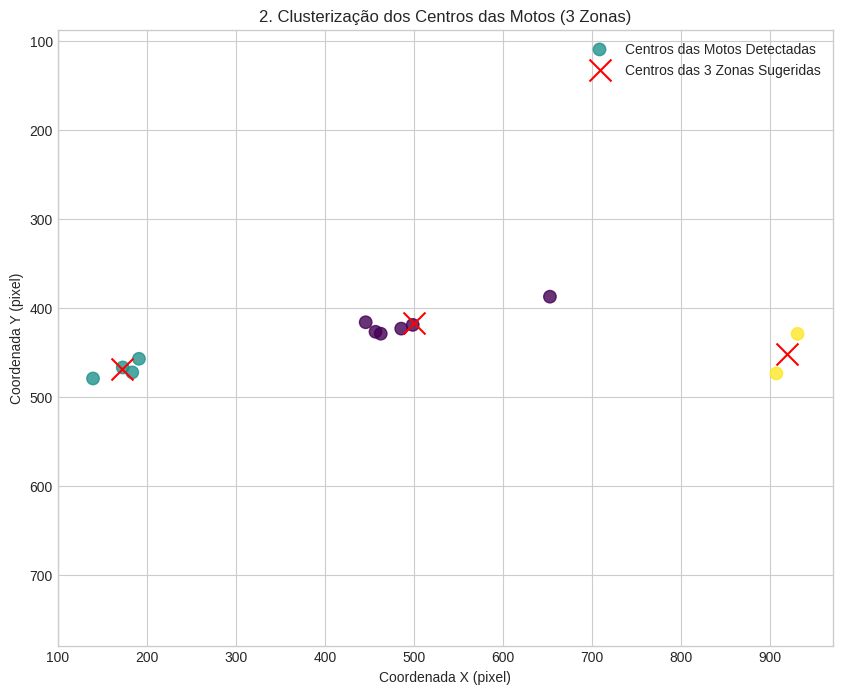

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

plt.scatter(
    detected_centers_np[:, 0],
    detected_centers_np[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=80,
    alpha=0.8,
    label='Centros das Motos Detectadas'
)

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='x',
    s=250,
    linewidth=1.5,
    label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas'
)

plt.title(f'2. Clusterização dos Centros das Motos ({NUM_CLUSTERS} Zonas)')
plt.xlabel("Coordenada X (pixel)")
plt.ylabel("Coordenada Y (pixel)")
plt.legend(loc='best')
plt.grid(True)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

E por fim, apenas uma visualização simples dos centróides na imagem

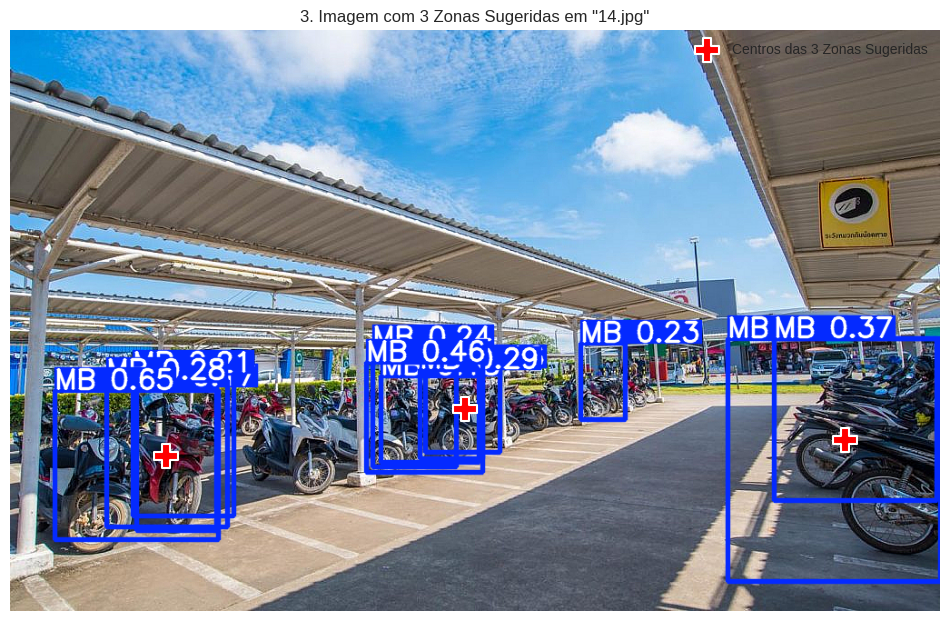

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
image_rgb_yolo_plot_for_zones = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_yolo_plot_for_zones)

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='P',
    s=300,
    edgecolor='white',
    linewidth=1.5,
    label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas'
)

plt.title(f'3. Imagem com {NUM_CLUSTERS} Zonas Sugeridas em "{IMAGE_TO_ANALYZE}"')
plt.legend(loc='best')
plt.axis('off')
plt.show()

## Fine Tuning (TO-DO - 2 entrega)

In [ ]:
NEW_EXPERIMENT_NAME = 'yolov8n_motorbike_finetune_run2_added_data'
NUM_EPOCHS_FINETUNE = 30
LEARNING_RATE_FINETUNE = 0.0005 # auto

In [ ]:
!yolo train model="{path_to_best_pt}" \
            data="{data_yaml_path}" \
            epochs={NUM_EPOCHS_FINETUNE} \
            imgsz=640 \
            batch=16 \
            project="{trained_models_dir}" \
            name="{NEW_EXPERIMENT_NAME}" \
            lr0={LEARNING_RATE_FINETUNE}
            # optimizer='auto'

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/yolov8n_motorbike_detector_run1/weights/best.pt, momentum=0.937, mosaic=1.0